## 0. Setup de librerías y funciones

In [1]:
# Antes tener instalados los paquetes:

# standard
import sys  
import warnings
warnings.filterwarnings('ignore')
from itertools import chain, cycle
import math
import numpy as np # linear algebra
from scipy import stats
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from cloudpickle import dump, load # model persistence

# for graphics
from IPython.display import display, HTML, display_html
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
#import plotly.graph_objects as go
#import plotly.express as px

# for the model
from sklearn.base import clone
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve, auc, RocCurveDisplay 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, FunctionTransformer

# for feature engineering
from feature_engine import imputation as imput
from feature_engine import encoding as enc
from feature_engine import discretisation as disc
from feature_engine import transformation as tr
from feature_engine import selection as sel
from feature_engine import wrappers as wrap


In [2]:
# Show up to 15 cols, 50 rows by default
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
# Suitable default display for floats
pd.options.display.float_format = '{:,.2f}'.format
#pd.options.styler.format.precision = 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)


In [3]:
#sys.path.insert(0, './dist')
import fa as fa

## 1. Carga de Datos y Análisis Exploratorio

In [4]:
df=pd.read_csv('Loan_Default_2.csv')

### Exploración inicial

Veamos las primeras filas del dataset.

In [5]:
df.head(10)

,ID,year,month,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,1.00,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.00,not_neg,not_int,not_lpsm,"118,000.00",sb,pr,home,1U,"1,740.00",EXP,758,CIB,25-34,to_inst,98.73,south,direct,1,45.00
1,24891,2019,1.00,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.00,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,"4,980.00",EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,1.00,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.20,595.00,360.00,neg_amm,not_int,not_lpsm,"508,000.00",sb,pr,home,1U,"9,480.00",EXP,834,CIB,35-44,to_inst,80.02,south,direct,0,46.00
3,24893,2019,1.00,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.68,NaN,360.00,not_neg,not_int,not_lpsm,"658,000.00",sb,pr,home,1U,"11,880.00",EXP,587,CIB,45-54,not_inst,69.38,North,direct,0,42.00
4,24894,2019,1.00,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.30,0.00,360.00,not_neg,not_int,not_lpsm,"758,000.00",sb,pr,home,1U,"10,440.00",CRIF,602,EXP,25-34,not_inst,91.89,North,direct,0,39.00
5,24895,2019,1.00,cf,Joint,pre,type1,p1,l1,nopc,nob/c,706500,3.99,0.15,370.00,360.00,not_neg,not_int,not_lpsm,"1,008,000.00",sb,pr,home,1U,"10,080.00",EXP,864,EXP,35-44,not_inst,70.09,North,direct,0,40.00
6,24896,2019,1.00,cf,Joint,pre,type1,p3,l1,nopc,nob/c,346500,4.50,1.00,"5,120.00",360.00,not_neg,not_int,not_lpsm,"438,000.00",sb,pr,home,1U,"5,040.00",EXP,860,EXP,55-64,to_inst,79.11,North,direct,0,44.00
7,24897,2019,1.00,NaN,Female,nopre,type1,p4,l1,nopc,nob/c,266500,4.12,0.30,"5,609.88",360.00,not_neg,not_int,not_lpsm,"308,000.00",sb,pr,home,1U,"3,780.00",CIB,863,CIB,55-64,to_inst,86.53,North,direct,0,42.00
8,24898,2019,1.00,cf,Joint,nopre,type1,p3,l1,nopc,nob/c,376500,4.88,0.74,"1,150.00",360.00,not_neg,not_int,not_lpsm,"478,000.00",sb,pr,home,1U,"5,580.00",CIB,580,EXP,55-64,to_inst,78.77,central,direct,0,44.00
9,24899,2019,1.00,cf,Sex Not Available,nopre,type3,p3,l1,nopc,nob/c,436500,3.49,-0.28,"2,316.50",360.00,not_neg,not_int,not_lpsm,"688,000.00",sb,pr,home,1U,"6,720.00",CIB,788,EXP,55-64,to_inst,63.44,south,direct,0,30.00


Status = 1 corresponde a la marca de Malo.  El desbalance es aceptable.  
Veamos ahora como se clasifican el resto de las variables en continuas, discretas o categóricas.  
En este ejemplo establecemos que las variables continuas son aquellas con más de 10 valores únicos y las discretas son aquellas numéricas con menos de 10 valores únicos. Por último las categóricas son todas las no numéricas. 

In [5]:
# Listas por tipos de variables
# numerical: discrete
discrete = [
    var for var in df.columns if df[var].dtype != 'O' and var != 'Status'
    and df[var].nunique() < 10
]

# numerical: continuous
continuous = [
    var for var in df.columns
    if df[var].dtype != 'O' and var != 'Status' and var not in discrete
]

# categorical
categorical = [var for var in df.columns if df[var].dtype == 'O']


#### Variables discretas

In [7]:
print('Variables discretas')
pd.DataFrame({'Variable': discrete}).pipe(display)

Variables discretas


,Variable
0,year


#### Variables continuas

In [8]:
print('Variables continuas')
pd.DataFrame({'Variable': continuous}).pipe(display)

Variables continuas


,Variable
0,ID
1,month
2,loan_amount
3,rate_of_interest
4,Interest_rate_spread
5,Upfront_charges
6,term
7,property_value
8,income
9,Credit_Score


#### Variables categóricas

In [9]:
print('Variables categóricas')
pd.DataFrame({'Variable': categorical}).pipe(display)

Variables categóricas


,Variable
0,loan_limit
1,Gender
2,approv_in_adv
3,loan_type
4,loan_purpose
5,Credit_Worthiness
6,open_credit
7,business_or_commercial
8,Neg_ammortization
9,interest_only


### Partición en Entrenamiento y Prueba

Para prevenir la fuga de datos ("data leakage") partimos un 70% de la muestra para entrenamiento y el resto para prueba.  Luego continuamos la exploración sólo usando los datos de entrenamiento. 
Primero mostramos la forma estándar de la industria de partición entre entrenamiento y prueba al azar.

In [6]:
# separate into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('Status', axis=1),  # predictors
    df['Status'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=101)  # seed to ensure reproducibility

print("Tamaños y cantidad de variables de Entrenamiento (_train) y Prueba (_test)")
print(X_train.shape, X_test.shape)

Tamaños y cantidad de variables de Entrenamiento (_train) y Prueba (_test)
(104069, 34) (44601, 34)


#### Prueba OOT 

A continuación mostramos como partir en base al valor de la columna "month". 
Elegimos como conjunto de prueba los últimos meses del dataset de ejemplo. 
Recordemos de todas formas que este columna no venía en los datos y la generamos al azar. 

In [7]:
X_test, X_train,  = [x for _, x in df.drop('Status', axis=1).groupby(df['month'] <= 8)]
y_test = df[df['month'] > 8]['Status']
y_train = df[df['month'] <= 8]['Status']

print("Tamaños y cantidad de variables de Entrenamiento (_train) y Prueba (_test)")
print(X_train.shape, X_test.shape)

Tamaños y cantidad de variables de Entrenamiento (_train) y Prueba (_test)
(99113, 34) (49557, 34)


### Análisis bivariados  

Exploramos la distribución de las predictoras según el target con la función `desc_cols_by_target(df, cols, target)`. Con ella podemos resumir la información de un grupo grande de columnas. Podemos así detectar gruesas diferencias según los valores de target y también evaluar la presencia de nulos. 


#### Discrete

In [12]:
fa.desc_cols_by_target(X_train, discrete, y_train)

,count,mean,std,min,25%,50%,75%,max,# missing,% missing
year by Status,,,,,,,,,,
0,74788,"2,019.00",0.00,"2,019.00","2,019.00","2,019.00","2,019.00","2,019.00",0,0.0%
1,24325,"2,019.00",0.00,"2,019.00","2,019.00","2,019.00","2,019.00","2,019.00",0,0.0%


La única discreta es el año, que es constante.  

#### Continuas

In [13]:
fa.desc_cols_by_target(X_train, continuous, y_train)

,count,mean,std,min,25%,50%,75%,max,# missing,% missing
ID by Status,,,,,,,,,,
0,74788,"74,466.51","28,645.39","24,892.00","49,618.50","74,450.50","99,328.25","124,002.00",0,0.0%
1,24325,"74,382.93","28,507.97","24,890.00","49,795.00","74,436.00","98,922.00","123,988.00",0,0.0%


,count,mean,std,min,25%,50%,75%,max,# missing,% missing
month by Status,,,,,,,,,,
0,74788,4.50,2.29,1.00,2.00,5.00,7.00,8.00,0,0.0%
1,24325,4.50,2.28,1.00,3.00,4.00,6.00,8.00,0,0.0%


,count,mean,std,min,25%,50%,75%,max,# missing,% missing
loan_amount by Status,,,,,,,,,,
0,74788,"334,709.61","174,581.31","26,500.00","206,500.00","306,500.00","446,500.00","3,006,500.00",0,0.0%
1,24325,"319,601.75","209,708.87","26,500.00","176,500.00","276,500.00","416,500.00","3,576,500.00",0,0.0%


,count,mean,std,min,25%,50%,75%,max,# missing,% missing
rate_of_interest by Status,,,,,,,,,,
0,74788,4.04,0.56,0.00,3.62,3.99,4.38,8.00,0,0.0%
1,136,4.36,0.47,3.38,3.99,4.38,4.75,5.50,24189,99.4%


,count,mean,std,min,25%,50%,75%,max,# missing,% missing
Interest_rate_spread by Status,,,,,,,,,,
0,74788,0.44,0.51,-3.64,0.08,0.39,0.77,3.36,0,0.0%
1,0,nan,nan,nan,nan,nan,nan,nan,24325,100.0%


,count,mean,std,min,25%,50%,75%,max,# missing,% missing
Upfront_charges by Status,,,,,,,,,,
0,72692,"3,240.80","3,265.38",0.00,585.85,"2,609.57","4,840.00","60,000.00",2096,2.8%
1,101,"1,623.17","2,464.64",0.00,0.00,812.98,"2,297.98","15,584.00",24224,99.6%


,count,mean,std,min,25%,50%,75%,max,# missing,% missing
term by Status,,,,,,,,,,
0,74769,335.27,58.69,96.00,360.00,360.00,360.00,360.00,19,0.0%
1,24313,335.04,57.17,96.00,360.00,360.00,360.00,360.00,12,0.0%


,count,mean,std,min,25%,50%,75%,max,# missing,% missing
property_value by Status,,,,,,,,,,
0,74788,"504,554.66","342,325.31","8,000.00","278,000.00","428,000.00","628,000.00","8,508,000.00",0,0.0%
1,14313,"458,429.68","435,941.85","8,000.00","228,000.00","348,000.00","558,000.00","16,508,000.00",10012,41.2%


,count,mean,std,min,25%,50%,75%,max,# missing,% missing
income by Status,,,,,,,,,,
0,69555,"7,185.28","6,322.26",0.00,"3,960.00","6,000.00","8,700.00","377,220.00",5233,7.0%
1,23506,"6,244.07","7,296.12",0.00,"3,000.00","4,860.00","7,620.00","578,580.00",819,3.4%


,count,mean,std,min,25%,50%,75%,max,# missing,% missing
Credit_Score by Status,,,,,,,,,,
0,74788,699.48,115.69,500.00,599.00,699.00,800.00,900.00,0,0.0%
1,24325,700.58,116.66,500.00,599.00,701.00,803.00,900.00,0,0.0%


,count,mean,std,min,25%,50%,75%,max,# missing,% missing
LTV by Status,,,,,,,,,,
0,74788,72.22,48.71,2.81,60.16,74.58,85.29,"7,831.25",0,0.0%
1,14313,76.53,31.71,0.97,64.72,79.52,90.95,"2,956.25",10012,41.2%


,count,mean,std,min,25%,50%,75%,max,# missing,% missing
dtir1 by Status,,,,,,,,,,
0,69620,37.44,9.97,5.00,31.00,39.00,44.00,61.00,5168,6.9%
1,13514,39.62,12.75,5.00,32.00,42.00,49.00,61.00,10811,44.4%


#### Categóricas

In [14]:
fa.desc_cols_by_target(X_train, categorical, y_train)

,count,unique,top,freq,# missing,% missing
loan_limit by Status,,,,,,
0,73129,2,cf,68684,1659,2.2%
1,23742,2,cf,21497,583,2.4%


,count,unique,top,freq,# missing,% missing
Gender by Status,,,,,,
0,74788,4,Joint,22238,0,0.0%
1,24325,4,Male,7346,0,0.0%


,count,unique,top,freq,# missing,% missing
approv_in_adv by Status,,,,,,
0,74333,2,nopre,62107,455,0.6%
1,24169,2,nopre,20964,156,0.6%


,count,unique,top,freq,# missing,% missing
loan_type by Status,,,,,,
0,74788,3,type1,58362,0,0.0%
1,24325,3,type1,17101,0,0.0%


,count,unique,top,freq,# missing,% missing
loan_purpose by Status,,,,,,
0,74722,4,p4,28130,66,0.1%
1,24307,4,p3,9293,18,0.1%


,count,unique,top,freq,# missing,% missing
Credit_Worthiness by Status,,,,,,
0,74788,2,l1,71919,0,0.0%
1,24325,2,l1,22977,0,0.0%


,count,unique,top,freq,# missing,% missing
open_credit by Status,,,,,,
0,74788,2,nopc,74489,0,0.0%
1,24325,2,nopc,24267,0,0.0%


,count,unique,top,freq,# missing,% missing
business_or_commercial by Status,,,,,,
0,74788,2,nob/c,65713,0,0.0%
1,24325,2,nob/c,19595,0,0.0%


,count,unique,top,freq,# missing,% missing
Neg_ammortization by Status,,,,,,
0,74734,2,not_neg,69201,54,0.1%
1,24307,2,not_neg,19761,18,0.1%


,count,unique,top,freq,# missing,% missing
interest_only by Status,,,,,,
0,74788,2,not_int,71366,0,0.0%
1,24325,2,not_int,23067,0,0.0%


,count,unique,top,freq,# missing,% missing
lump_sum_payment by Status,,,,,,
0,74788,2,not_lpsm,74281,0,0.0%
1,24325,2,not_lpsm,22614,0,0.0%


,count,unique,top,freq,# missing,% missing
construction_type by Status,,,,,,
0,74788,1,sb,74788,0,0.0%
1,24325,2,sb,24307,0,0.0%


,count,unique,top,freq,# missing,% missing
occupancy_type by Status,,,,,,
0,74788,3,pr,69927,0,0.0%
1,24325,3,pr,22309,0,0.0%


,count,unique,top,freq,# missing,% missing
Secured_by by Status,,,,,,
0,74788,1,home,74788,0,0.0%
1,24325,2,home,24307,0,0.0%


,count,unique,top,freq,# missing,% missing
total_units by Status,,,,,,
0,74788,4,1U,73859,0,0.0%
1,24325,4,1U,23822,0,0.0%


,count,unique,top,freq,# missing,% missing
credit_type by Status,,,,,,
0,74788,4,CIB,27029,0,0.0%
1,24325,4,EQUI,10149,0,0.0%


,count,unique,top,freq,# missing,% missing
co-applicant_credit_type by Status,,,,,,
0,74788,2,CIB,40629,0,0.0%
1,24325,2,EXP,15192,0,0.0%


,count,unique,top,freq,# missing,% missing
age by Status,,,,,,
0,74788,7,45-54,17596,0,0.0%
1,24189,7,45-54,5599,136,0.6%


,count,unique,top,freq,# missing,% missing
submission_of_application by Status,,,,,,
0,74788,2,to_inst,45860,0,0.0%
1,24189,2,to_inst,18047,136,0.6%


,count,unique,top,freq,# missing,% missing
Region by Status,,,,,,
0,74788,4,North,38757,0,0.0%
1,24325,4,south,11335,0,0.0%


,count,unique,top,freq,# missing,% missing
Security_Type by Status,,,,,,
0,74788,1,direct,74788,0,0.0%
1,24325,2,direct,24307,0,0.0%


#### Gráficos bivariados para continuas

Para analizar en detalle la relación entre una variable continua y el target podemos usar la función `plot_bivar_cont(df, target, cols=None, vis_col=2, target_lbl = 'target', nbins=10, discr_round=3)`.  
Esta función por defecto redondea a 3 dígitos decimales, parte en 10 bines y grafica en 2 columnas de visualización.

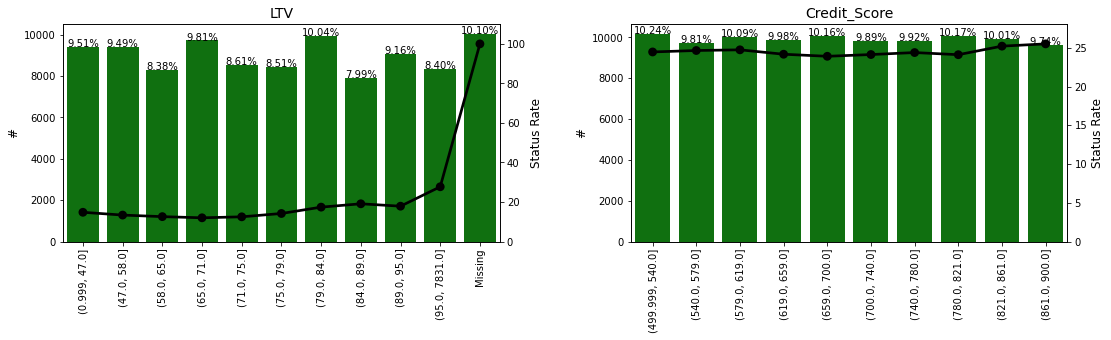

In [15]:
X_train.pipe(fa.plot_bivar_cont, target = y_train, cols = ['LTV', 'Credit_Score'], target_lbl = 'Status', discr_round=0)

#### Gráficos bivariados para categóricas

Podemos estudiar en detalle la distribución de una variable categórica según el target con la función `plot_bivar_cat(df, target, cols=None, vis_col=2, target_lbl = 'target', max_n_vals=20, discr_round=3)`.

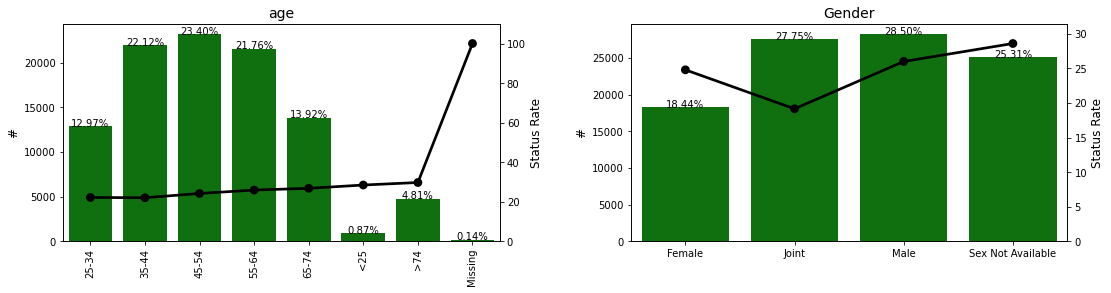

In [16]:
X_train.pipe(fa.plot_bivar_cat, target = y_train, cols = ['age', 'Gender'], target_lbl = 'Status')

### Identificación de variables no predictoras  

A partir de los análsis hechos actualizamos los conjuntos de variables eliminando las variables que identificamos como no predictoras o problemáticas. La variable "month" la identificamos cómo no predictora pero la tratamos de forma separada porque la usaremos en la etapa de eliminación de variables inestables. 

In [8]:
# Eliminación de variables problemáticas
no_pred = ['ID', 'year']
no_pred_psi = 'month'
problematicas = ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'property_value', 'LTV', 'dtir1']
continuous = [i for i in continuous if i not in (problematicas + no_pred + [no_pred_psi])]  
discrete = [i for i in discrete if i not in (problematicas + no_pred + [no_pred_psi])]  
categorical = [i for i in categorical if i not in (problematicas + no_pred + [no_pred_psi])]  

## 2. ML Pipeline

Con los roles ya definidos vamos ahora a construir un Pipeline de scikit-learn: https://scikit-learn.org/stable/modules/compose.html para implementar en un sólo paso la transformación de variables y el ajuste del modelo logístico.  

### Definición del Pipeline

Para la transformación de variables usaremos la excelente librería "Feature Engine"  
https://feature-engine.readthedocs.io/en/latest/index.html

Los pasos que construimos son:
1) Agrupación de variables 
2) Transformación por WoE 
3) Eliminamos variables cuasi constantes y con PSI alto
4) Entrenamos una regresión logística

In [18]:

# Convertimos las discretas numéricas a string para proceso posterior. 
disc_disc = wrap.SklearnTransformerWrapper(transformer = FunctionTransformer(func = lambda x: x.astype(str)), 
                                           variables = discrete)

# Imputación de nulos de continuas para proceso posterior
cont_imp = imput.MeanMedianImputer(imputation_method = 'mean', variables=continuous)

# Imputación de nulos de las variables categóricas y discretas para proceso posterior
cat_imp = imput.CategoricalImputer(imputation_method='missing', fill_value='Nulo', return_object=True, 
                                   variables = categorical + discrete)
# 1) Agrupación de variables.
# Discretización de continuas 
cont_disc = disc.EqualFrequencyDiscretiser(q=10, variables=continuous, return_object=True) # importante: retornar como categórica

# Agrupación de discretizadas por árboles de decisión
cat_dt = enc.DecisionTreeEncoder(encoding_method='ordered', cv=3, scoring = 'roc_auc', 
                                 param_grid = {'max_depth': [1, 2], 'min_samples_leaf': [0.05]},
                                 regression = False, variables=['age'])

cat_dt_disc = wrap.SklearnTransformerWrapper(transformer = FunctionTransformer(func = lambda x: x.astype(str)), 
                                             variables = ['age'])

# 2) Transformación por WoE
woe = fa.WoEEncoderZeroTreat(variables = categorical + discrete + continuous)

# Asignamos un WoE de cero a las muy poco frecuentes
cat_ralas = enc.RareLabelEncoder(tol=0.025, n_categories=2, max_n_categories=10, replace_with=0, 
                                 ignore_format = True, variables = categorical + discrete + continuous)

# Restauramos el formato numérico de los WoE
cat_2_num = wrap.SklearnTransformerWrapper(transformer = FunctionTransformer(func = lambda x: x.astype(float)), 
                                           variables = categorical + discrete + continuous)

# Eliminación de problemáticas
quitar_probl = sel.DropFeatures(features_to_drop = problematicas + no_pred)
quitar_var_psi = sel.DropFeatures(features_to_drop = no_pred_psi)

# 3) Eliminamos variables cuasi constantes y con PSI alto

# Eliminación de quasi constantes (con hasta el 97.5 de las observaciones con un único valor).
quitar_const = sel.DropConstantFeatures(variables=None, tol=0.975, missing_values='include')

# Eliminamos variables con Population Stability Index, PSI > 0.25 
quitar_inest = sel.DropHighPSIFeatures(split_col='month', cut_off=5, threshold = 0.25)

# Regresión Logística
reg_log = LogisticRegression(random_state=101)



In [9]:
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline

In [20]:
# pipeline
model_pipe = PMMLPipeline(steps=[
    # ('ConvStr', disc_disc),  # Quitamos este paso porque no quedan discretas en este ejemplo  
    ('ImputarMedias', cont_imp),
    ('ImputarCateg', cat_imp),    
    ('DiscXDeciles', cont_disc),
    ('AgrupCategxDT', cat_dt),
    ('ConvStrDT', cat_dt_disc), 
    ('CodifWoE', woe),
    ('AgrupRaras', cat_ralas),            
    ('ANum', cat_2_num), 
    ('QuitarProblem', quitar_probl),
    ('QuitarQuasiConst', quitar_const),    
    ('QuitarInest', quitar_inest),    
    ('QuitarPSIVar', quitar_var_psi), 
    ('logit', reg_log)
    ])

### Construcción del modelo ALL

Primero aplicamos el pipeline sobre todo el conjunto de entrenamiento para desarrollar el primer modelo, que llamamos ALL.

In [21]:
model_pipe.fit(X_train, y_train)

PMMLPipeline(steps=[('ImputarMedias', MeanMedianImputer(imputation_method='mean',
                  variables=['loan_amount', 'term', 'income', 'Credit_Score'])),
       ('ImputarCateg', CategoricalImputer(fill_value='Nulo', return_object=True,
                   variables=['loan_limit', 'Gender', 'approv_in_adv',
                              'loan_type', 'loan_purpose', 'Credit_Worthiness',
                              'open_credit', 'business_or_commercial',
                              'Neg_ammortization', 'interest_only',
                              'lump_sum_payment', 'construction_type',
                              'occupancy_type', 'Secured_by', 'total_units',
                              'credit_type', 'co-applicant_credit_type', 'age',
                              'submission_of_application', 'Region',
                              'Security_Type'])),
       ('DiscXDeciles', EqualFrequencyDiscretiser(return_object=True,
                          variables=['loan_amount', 'term', 'income',
                                     'Credit_Score'])),
       ('AgrupCategxDT', DecisionTreeEncoder(encoding_method='ordered',
                    param_grid={'max_depth': [1, 2],
                                'min_samples_leaf': [0.05]},
                    regression=False, scoring='roc_auc', variables=['age'])),
       ('ConvStrDT', SklearnTransformerWrapper(transformer=FunctionTransformer(func=<function <lambda> at 0x7f7a75c8a830>),
                          variables=['age'])),
       ('CodifWoE', WoEEncoderZeroTreat(variables=['loan_limit', 'Gender', 'approv_in_adv',
                               'loan_type', 'loan_purpose', 'Credit_Worthiness',
                               'open_credit', 'business_or_commercial',
                               'Neg_ammortization', 'interest_only',
                               'lump_sum_payment', 'construction_type',
                               'occupancy_type', 'Secured_by', 'total_units',
                               'credit_type', 'co-applicant_credit_type', 'age',
                               'submission_of_application', 'Region',
                               'Security_Type', 'loan_amount', 'term', 'income',
                               'Credit_Score'])),
       ('AgrupRaras', RareLabelEncoder(ignore_format=True, max_n_categories=10, n_categories=2,
                 replace_with=0, tol=0.025,
                 variables=['loan_limit', 'Gender', 'approv_in_adv',
                            'loan_type', 'loan_purpose', 'Credit_Worthiness',
                            'open_credit', 'business_or_commercial',
                            'Neg_ammortization', 'interest_only',
                            'lump_sum_payment', 'construction_type',
                            'occupancy_type', 'Secured_by', 'total_units',
                            'credit_type', 'co-applicant_credit_type', 'age',
                            'submission_of_application', 'Region',
                            'Security_Type', 'loan_amount', 'term', 'income',
                            'Credit_Score'])),
       ('ANum', SklearnTransformerWrapper(transformer=FunctionTransformer(func=<function <lambda> at 0x7f7a75c8bc70>),
                          variables=['loan_limit', 'Gender', 'approv_in_adv',
                                     'loan_type', 'loan_purpose',
                                     'Credit_Worthiness', 'open_credit',
                                     'business_or_commercial',
                                     'Neg_ammortization', 'interest_only',
                                     'lump_sum_payment', 'construction_type',
                                     'occupancy_type', 'Secured_by',
                                     'total_units', 'credit_type',
                                     'co-applicant_credit_type', 'age',
                                     'submission_of_application', 'Region',
                                     'Security_Type', 'loan_amount', 

In [25]:
# Preproceso
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn2pmml.decoration import CategoricalDomain, ContinuousDomain
from sklearn2pmml.preprocessing import ExpressionTransformer, LookupTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

# Modelos
from sklearn.linear_model import LogisticRegression

mapper = DataFrameMapper([
	(["income", "Credit_Score"], [ContinuousDomain(), SimpleImputer(missing_values=np.nan, strategy='mean'), 
        KBinsDiscretizer(encode="onehot", random_state=101)
      ]), 
	(["occupancy_type"], [CategoricalDomain(), OneHotEncoder(drop = "first")])
])

model_pipe = PMMLPipeline([
	("mapper", mapper),
	("classifier", LogisticRegression(random_state=101))
])



In [22]:
X_train_rec = X_train[["income", "Credit_Score", "occupancy_type"]]

In [23]:
X_train_rec.to_csv('X_train_rec.csv')

In [26]:
model_pipe.fit(X_train_rec, y_train)


PMMLPipeline(steps=[('mapper', DataFrameMapper(drop_cols=[],
                features=[(['income', 'Credit_Score'],
                           [ContinuousDomain(), SimpleImputer(),
                            KBinsDiscretizer(random_state=101)]),
                          (['occupancy_type'],
                           [CategoricalDomain(), OneHotEncoder(drop='first')])])),
       ('classifier', LogisticRegression(random_state=101))])

In [27]:
model_pipe.verify(X_train_rec.sample(100))

In [15]:
with open("Modelo_PMML_v1_ALL.pkl", "wb") as pkl_file:
        dump(model_pipe, pkl_file)

In [16]:
with open("Modelo_PMML_v1_ALL.pkl", "rb") as pkl_file:
        model_pipe = load(pkl_file)

In [28]:
sklearn2pmml(model_pipe, "Modelo_logistico_v1_ALL.pmml.xml")

In [31]:
scores_rec = pd.read_csv("X_train_rec_eval.csv")
scores_rec.sample()

,Status,probability(0),probability(1)
93731,0,0.63,0.37


In [41]:
rep = fa.model_report(score = scores_rec.loc[:,'probability(1)'], 
                      target = y_train, quantiles=10, 
                      score_model_name='Modelo Logistico ALL en toda la Muestra')

Modelo Logistico ALL en toda la Muestra performance report


,cuantil,prob,count,event,non_event,event_rate,odds,per_event,per_non_event,per_event_cmlt,per_non_event_cmlt,lift,KS
0,"(0.0, 0.176]",17.5%,11845,2011,9834,17.0%,0.20,8.3%,13.1%,8.3%,13.1%,0.69,4.9%
1,"(0.176, 0.188]",18.3%,11081,2042,9039,18.4%,0.23,8.4%,12.1%,16.7%,25.2%,0.75,8.6%
2,"(0.188, 0.194]",19.3%,10135,1971,8164,19.4%,0.24,8.1%,10.9%,24.8%,36.2%,0.79,11.4%
3,"(0.194, 0.211]",20.5%,7024,1492,5532,21.2%,0.27,6.1%,7.4%,30.9%,43.5%,0.87,12.7%
4,"(0.211, 0.217]",21.6%,10784,2354,8430,21.8%,0.28,9.7%,11.3%,40.6%,54.8%,0.89,14.2%
5,"(0.217, 0.251]",24.1%,12457,2954,9503,23.7%,0.31,12.1%,12.7%,52.7%,67.5%,0.97,14.8%
6,"(0.251, 0.253]",25.3%,8058,2035,6023,25.3%,0.34,8.4%,8.1%,61.1%,75.6%,1.03,14.5%
7,"(0.253, 0.326]",26.9%,7914,2109,5805,26.6%,0.36,8.7%,7.8%,69.8%,83.3%,1.09,13.6%
8,"(0.326, 0.367]",36.4%,11683,4289,7394,36.7%,0.58,17.6%,9.9%,87.4%,93.2%,1.50,5.8%
9,"(0.367, 1.0]",38.0%,8132,3068,5064,37.7%,0.61,12.6%,6.8%,100.0%,100.0%,1.54,0.0%


In [ ]:
rep = fa.model_report(score = model_pipe.predict_proba(X_train_rec)[:,1], 
                      target = y_train, quantiles=10, 
                      score_model_name='Modelo Logistico ALL en toda la Muestra')

Modelo Logistico ALL en toda la Muestra performance report


,cuantil,prob,count,event,non_event,event_rate,odds,per_event,per_non_event,per_event_cmlt,per_non_event_cmlt,lift,KS
0,"(0.0, 0.176]",17.5%,11845,2011,9834,17.0%,0.20,8.3%,13.1%,8.3%,13.1%,0.69,4.9%
1,"(0.176, 0.188]",18.3%,11081,2042,9039,18.4%,0.23,8.4%,12.1%,16.7%,25.2%,0.75,8.6%
2,"(0.188, 0.194]",19.3%,10135,1971,8164,19.4%,0.24,8.1%,10.9%,24.8%,36.2%,0.79,11.4%
3,"(0.194, 0.211]",20.5%,7024,1492,5532,21.2%,0.27,6.1%,7.4%,30.9%,43.5%,0.87,12.7%
4,"(0.211, 0.217]",21.6%,10784,2354,8430,21.8%,0.28,9.7%,11.3%,40.6%,54.8%,0.89,14.2%
5,"(0.217, 0.251]",24.1%,12457,2954,9503,23.7%,0.31,12.1%,12.7%,52.7%,67.5%,0.97,14.8%
6,"(0.251, 0.253]",25.3%,8058,2035,6023,25.3%,0.34,8.4%,8.1%,61.1%,75.6%,1.03,14.5%
7,"(0.253, 0.326]",26.9%,7914,2109,5805,26.6%,0.36,8.7%,7.8%,69.8%,83.3%,1.09,13.6%
8,"(0.326, 0.367]",36.4%,11683,4289,7394,36.7%,0.58,17.6%,9.9%,87.4%,93.2%,1.50,5.8%
9,"(0.367, 1.0]",38.0%,8132,3068,5064,37.7%,0.61,12.6%,6.8%,100.0%,100.0%,1.54,0.0%


### Exploración de transformaciones

Veamos como quedó el conjunto de entrenamiento transformado por el pipeline justo antes del último paso que realiza el ajuste del modelo logístico.

In [24]:
X_train_t = model_pipe[:-1].transform(X_train)
X_train_t.head()

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,business_or_commercial,loan_amount,term,Neg_ammortization,interest_only,occupancy_type,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,Region
0,-0.038434,0.208828,0.037117,-0.104355,0.064408,-0.017879,-0.086852,0.408150,0.01366,-0.130134,-0.006251,-0.019294,0.844028,-0.545472,-0.007315,-0.369393,-0.140745,0.190556,0.109153
1,-0.038434,0.077604,0.037117,0.471605,0.064408,-0.017879,0.471605,0.071238,0.01366,-0.130134,-0.006251,-0.019294,-0.026138,9.942867,0.007045,0.312914,0.087667,0.190556,-0.124482
2,-0.038434,0.077604,-0.215585,-0.104355,0.064408,-0.017879,-0.086852,-0.163486,0.01366,0.926690,-0.006251,-0.019294,-0.279994,-0.545472,0.037135,-0.369393,-0.140745,0.190556,0.109153
3,-0.038434,0.077604,0.037117,-0.104355,-0.086363,-0.017879,-0.086852,-0.218256,0.01366,-0.130134,-0.006251,-0.019294,-0.279994,-0.545472,0.011702,-0.369393,-0.021870,-0.426443,-0.124482
4,-0.038434,-0.316547,-0.215585,-0.104355,0.064408,-0.017879,-0.086852,-0.004474,0.01366,-0.130134,-0.006251,-0.019294,-0.279994,-0.517046,0.011702,0.312914,-0.140745,-0.426443,-0.124482


Comprobamos que el modelo logístico se aplica a las variables transformadas por WoE.  
Veamos en detalle dos variables, antes y después de las transformaciones.

### Exploración de transformaciones por WoE

Con la función `plot_bivar_cat()` que aprendimos en la sección de Gráficos bivariados podemos comparar el antes y después de la transformación por WoE.

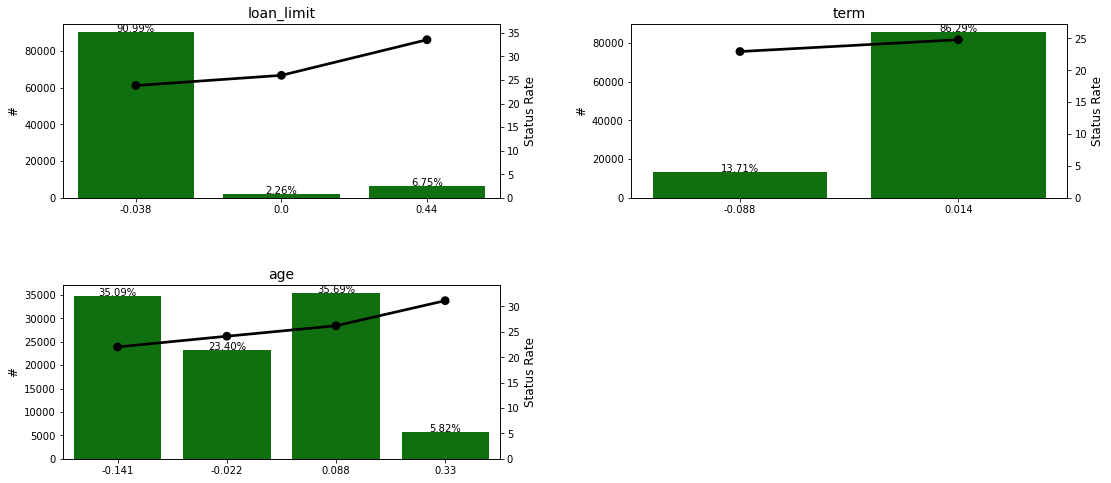

In [25]:
X_train_t.pipe(fa.plot_bivar_cat, target = y_train, cols = ['loan_limit', 'term', 'age'], target_lbl = 'Status')

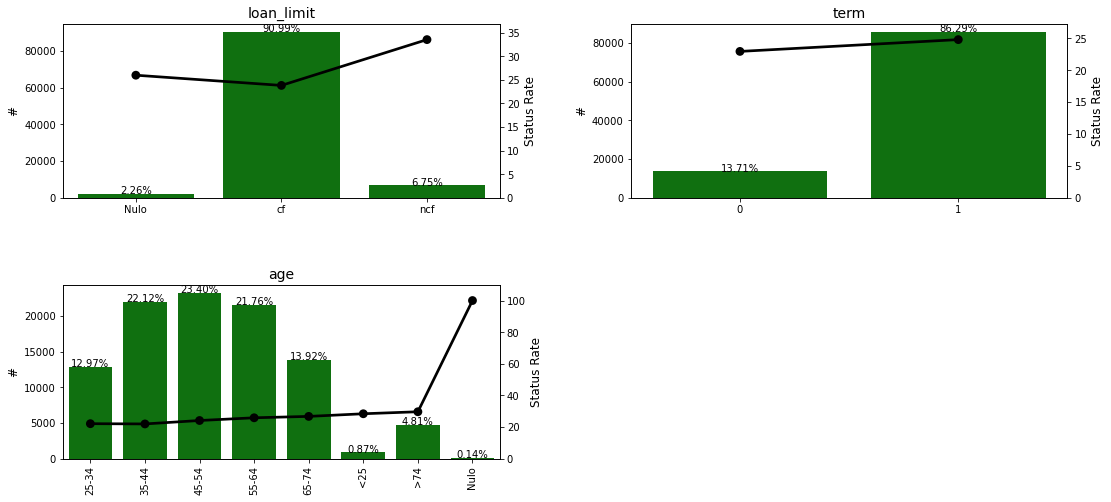

In [27]:
model_pipe[:3].transform(X_train).pipe(fa.plot_bivar_cat, target = y_train, cols = ['loan_limit', 'term', 'age'], 
                                       target_lbl = 'Status')

Podemos observar que la codificación por WoE asegura la monotonía. 

## 3. Resumen del Entrenamiento

En esta sección presentamos el resultado de la selección de variables y los coeficientes del modelo logístico.  
Recordemos que ajustamos un modelo para estimar el evento target = 1.  Si este evento significa ser "malo", a mayor score, mayor será la probabilidad de ser "malo". 

### Coeficientes del modelo

Al estar codificadas por WoE los coeficientes están relacionados con la importancia de la variable dentro del modelo. 
Usamos la función `model_coef(model_pipeline, title)` para graficarlos.   

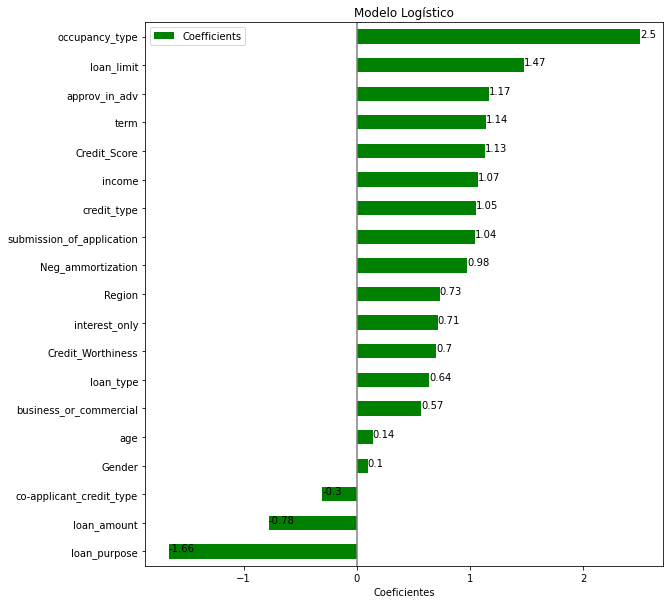

In [26]:
fa.model_coef(model_pipe, "Modelo Logístico")

## 4. Predicciones del Modelo 

Con la función de scikit-learn `predict_proba()` obtenemos los scores (en probabilidades) resultantes de aplicar el modelo al dataset dado como argumento. 
Ref: 
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba

De esta manera aplicamos el modelo a los conjuntos de entrenamiento (train) y prueba (test).  
Notemos que la funcion `predict_proba()` devuelve dos columnas.  Elegimos la segunda para estimar la probabilidad de target = 1. 

In [49]:
y_train_score = model_pipe.predict_proba(X_train[continuous])[:,1]
y_test_score = model_pipe.predict_proba(X_test[continuous])[:,1]
y_all_score = np.concatenate((y_train_score, y_test_score))

## 5. Persistencia del Modelo

Con el siguiente código mostramos como podemos salvar el modelo a un archivo y cargar un modelo desde un archivo. 

In [26]:
with open("Modelo_PMML_v1_ALL.pkl", "wb") as pkl_file:
        dump(model_pipe, pkl_file)

In [27]:
with open("Modelo_PMML_v1_ALL.pkl", "rb") as pkl_file:
        model_pipe = load(pkl_file)

In [29]:
conda list | grep cloud

cloudpickle               2.1.0              pyhd8ed1ab_0    conda-forge

Note: you may need to restart the kernel to use updated packages.


In [ ]:
with open("Modelo_logistico_v1_ALL.pkl", "rb") as pkl_file:
        mod_all = load(pkl_file)

De esta forma cargamos el modelo desarrollado en el objeto mod_all.  
En la siguiente celda verificamos que las predicciones de este objeto coinciden con las originales. 

In [30]:
y_test_score_verif = mod_all.predict_proba(X_test)[:,1]
all(y_test_score_verif == y_test_score)

True

## 6. Performance del Modelo

Evaluamos aquí la performance del modelo, que llamamos ALL, por ser aplicado a toda la población.

Con la función `bsl_vs_test_report(bsl_score, bsl_target, test_score, test_target, nbins=10, score_model_name='Modelo v1')` realizamos en un paso la comparación entre dos scores que pueden surgir de dos modelos o de un mismo modelo aplicados a dos datasets.  Al primer score lo llamamos "Baseline" y al segundo "Test". 

### Entrenamiento vs Prueba

En la siguiente celda verificamos la estabilidad del modelo realizando la comparación entre los scores del modelo ALL aplicados a los datos de Entrenamiento y a los datos de la Prueba en otro período. 

ALL Train vs. Test OOT Baseline performance report


,cuantil,prob,count,event,non_event,event_rate,odds,per_event,per_non_event,per_event_cmlt,per_non_event_cmlt,lift,KS
0,"(0.0, 0.176]",17.1%,11722,2156,9566,18.4%,0.23,8.9%,12.8%,8.9%,12.8%,0.75,3.9%
1,"(0.176, 0.193]",18.7%,9880,1852,8028,18.7%,0.23,7.6%,10.7%,16.5%,23.5%,0.76,7.0%
2,"(0.193, 0.201]",19.8%,9057,1699,7358,18.8%,0.23,7.0%,9.8%,23.5%,33.4%,0.76,9.9%
3,"(0.201, 0.216]",21.1%,10953,2361,8592,21.6%,0.27,9.7%,11.5%,33.2%,44.9%,0.88,11.7%
4,"(0.216, 0.22]",21.9%,9636,2064,7572,21.4%,0.27,8.5%,10.1%,41.7%,55.0%,0.87,13.3%
5,"(0.22, 0.24]",23.0%,8450,1892,6558,22.4%,0.29,7.8%,8.8%,49.4%,63.7%,0.91,14.3%
6,"(0.24, 0.257]",25.0%,10615,2545,8070,24.0%,0.32,10.5%,10.8%,59.9%,74.5%,0.98,14.6%
7,"(0.257, 0.285]",26.4%,9082,2401,6681,26.4%,0.36,9.9%,8.9%,69.8%,83.5%,1.08,13.7%
8,"(0.285, 0.373]",35.9%,10138,3503,6635,34.6%,0.53,14.4%,8.9%,84.2%,92.3%,1.41,8.2%
9,"(0.373, 1.0]",38.1%,9580,3852,5728,40.2%,0.67,15.8%,7.7%,100.0%,100.0%,1.64,0.0%


ALL Train vs. Test OOT Testing performance report


,cuantil,prob,count,event,non_event,event_rate,odds,per_event,per_non_event,per_event_cmlt,per_non_event_cmlt,lift,KS
0,"(0.0, 0.176]",17.1%,5905,1130,4775,19.1%,0.24,9.2%,12.8%,9.2%,12.8%,0.77,3.6%
1,"(0.176, 0.193]",18.7%,5114,960,4154,18.8%,0.23,7.8%,11.2%,17.0%,24.0%,0.76,7.0%
2,"(0.193, 0.201]",19.8%,4443,828,3615,18.6%,0.23,6.7%,9.7%,23.7%,33.7%,0.75,10.0%
3,"(0.201, 0.216]",21.1%,5491,1179,4312,21.5%,0.27,9.6%,11.6%,33.3%,45.3%,0.86,12.0%
4,"(0.216, 0.22]",21.9%,4974,1065,3909,21.4%,0.27,8.6%,10.5%,41.9%,55.8%,0.86,13.8%
5,"(0.22, 0.24]",23.0%,4193,986,3207,23.5%,0.31,8.0%,8.6%,49.9%,64.4%,0.95,14.4%
6,"(0.24, 0.257]",25.0%,5196,1303,3893,25.1%,0.33,10.6%,10.5%,60.5%,74.8%,1.01,14.3%
7,"(0.257, 0.285]",26.4%,4383,1148,3235,26.2%,0.35,9.3%,8.7%,69.8%,83.5%,1.05,13.7%
8,"(0.285, 0.373]",35.9%,5215,1860,3355,35.7%,0.55,15.1%,9.0%,84.9%,92.5%,1.44,7.6%
9,"(0.373, 1.0]",38.0%,4643,1855,2788,40.0%,0.67,15.1%,7.5%,100.0%,100.0%,1.61,0.0%


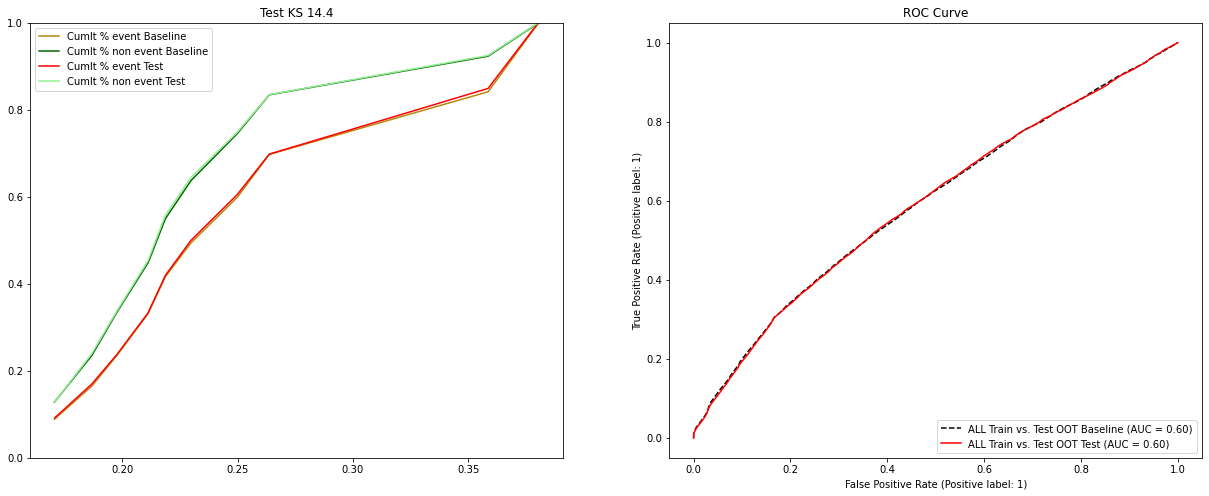

In [50]:
rep = fa.bsl_vs_test_report(bsl_score = y_train_score, bsl_target = y_train, 
                         test_score = y_test_score, test_target = y_test, 
                         nbins=10, score_model_name='ALL Train vs. Test OOT')

### en toda la Muestra

A veces se necesita sólo el reporte de performance. En ese caso empleamos la función `model_report(score, target, quantiles, score_model_name)`.  

In [32]:
rep = fa.model_report(score = y_all_score, target = df['Status'], quantiles=10, 
                   score_model_name='Modelo Logistico ALL en toda la Muestra')

Modelo Logistico ALL en toda la Muestra performance report


,cuantil,prob,count,event,non_event,event_rate,odds,per_event,per_non_event,per_event_cmlt,per_non_event_cmlt,lift,KS
0,"(0.0, 0.066]",5.6%,15412,908,14504,5.9%,0.06,2.5%,12.9%,2.5%,12.9%,0.24,10.5%
1,"(0.066, 0.083]",7.5%,14557,992,13565,6.8%,0.07,2.7%,12.1%,5.2%,25.1%,0.28,19.9%
2,"(0.083, 0.102]",9.3%,15147,1429,13718,9.4%,0.10,3.9%,12.2%,9.1%,37.3%,0.38,28.2%
3,"(0.102, 0.121]",11.2%,15037,1720,13317,11.4%,0.13,4.7%,11.9%,13.8%,49.2%,0.46,35.4%
4,"(0.121, 0.141]",13.1%,14225,1894,12331,13.3%,0.15,5.2%,11.0%,18.9%,60.2%,0.54,41.2%
5,"(0.141, 0.169]",15.5%,15142,2272,12870,15.0%,0.18,6.2%,11.5%,25.2%,71.7%,0.61,46.5%
6,"(0.169, 0.212]",18.9%,14733,2865,11868,19.4%,0.24,7.8%,10.6%,33.0%,82.3%,0.79,49.3%
7,"(0.212, 0.286]",24.6%,14702,3706,10996,25.2%,0.34,10.1%,9.8%,43.1%,92.1%,1.02,49.0%
8,"(0.286, 1.0]",70.3%,29715,20853,8862,70.2%,2.35,56.9%,7.9%,100.0%,100.0%,2.85,0.0%
9,"(0.0, 1.0]",24.6%,148670,36639,112031,24.6%,0.33,100.0%,100.0%,100.0%,100.0%,1.00,49.3%


### en toda la Muestra con cortes prefijados

Podemos también evaluar la performance con cortes prefijados de la siguiente manera:

In [33]:
rep = fa.model_report(score = y_all_score, target = df['Status'], quantiles=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 1], 
                   score_model_name='Modelo Logistico ALL en toda la Muestra con cortes prefijados')

Modelo Logistico ALL en toda la Muestra con cortes prefijados performance report


,cuantil,prob,count,event,non_event,event_rate,odds,per_event,per_non_event,per_event_cmlt,per_non_event_cmlt,lift,KS
0,"(0.0, 0.05]",4.5%,3783,205,3578,5.4%,0.06,0.6%,3.2%,0.6%,3.2%,0.22,2.6%
1,"(0.05, 0.1]",7.6%,39666,2953,36713,7.4%,0.08,8.1%,32.8%,8.6%,36.0%,0.30,27.3%
2,"(0.1, 0.15]",12.4%,36320,4499,31821,12.4%,0.14,12.3%,28.4%,20.9%,64.4%,0.50,43.5%
3,"(0.15, 0.2]",17.3%,20947,3682,17265,17.6%,0.21,10.0%,15.4%,30.9%,79.8%,0.71,48.8%
4,"(0.2, 0.25]",22.4%,12222,2810,9412,23.0%,0.30,7.7%,8.4%,38.6%,88.2%,0.93,49.6%
5,"(0.25, 0.3]",27.3%,7862,2154,5708,27.4%,0.38,5.9%,5.1%,44.5%,93.3%,1.11,48.8%
6,"(0.3, 0.5]",37.4%,10803,4040,6763,37.4%,0.60,11.0%,6.0%,55.5%,99.3%,1.52,43.8%
7,"(0.5, 1.0]",95.7%,17067,16296,771,95.5%,21.14,44.5%,0.7%,100.0%,100.0%,3.87,0.0%
8,"(0.0, 1.0]",24.6%,148670,36639,112031,24.6%,0.33,100.0%,100.0%,100.0%,100.0%,1.00,49.6%


### en toda la Muestra con cortes prefijados de Entrenamiento

Podemos también evaluar la performance manteniendo los bins obtenidos en el conjunto de prueba usando la función de ayuda `bins(scores, nbins=10, left_limit=0, right_limit=1)` de la siguiente manera:

In [36]:
rep = fa.model_report(score = y_all_score, target = df['Status'], quantiles=fa.bins(y_train_score, 10), 
                   score_model_name='Modelo Logistico ALL en toda la Muestra con cortes prefijados')

Modelo Logistico ALL en toda la Muestra con cortes prefijados performance report


,cuantil,prob,count,event,non_event,event_rate,odds,per_event,per_non_event,per_event_cmlt,per_non_event_cmlt,lift,KS
0,"(0.0, 0.066]",5.6%,15412,908,14504,5.9%,0.06,2.5%,12.9%,2.5%,12.9%,0.24,10.5%
1,"(0.066, 0.083]",7.5%,14557,992,13565,6.8%,0.07,2.7%,12.1%,5.2%,25.1%,0.28,19.9%
2,"(0.083, 0.102]",9.3%,15147,1429,13718,9.4%,0.10,3.9%,12.2%,9.1%,37.3%,0.38,28.2%
3,"(0.102, 0.121]",11.2%,15037,1720,13317,11.4%,0.13,4.7%,11.9%,13.8%,49.2%,0.46,35.4%
4,"(0.121, 0.141]",13.1%,14225,1894,12331,13.3%,0.15,5.2%,11.0%,18.9%,60.2%,0.54,41.2%
5,"(0.141, 0.169]",15.5%,15142,2272,12870,15.0%,0.18,6.2%,11.5%,25.2%,71.7%,0.61,46.5%
6,"(0.169, 0.211]",18.9%,14452,2805,11647,19.4%,0.24,7.7%,10.4%,32.8%,82.1%,0.79,49.3%
7,"(0.211, 0.286]",24.5%,14983,3766,11217,25.1%,0.34,10.3%,10.0%,43.1%,92.1%,1.02,49.0%
8,"(0.286, 1.0]",70.3%,29715,20853,8862,70.2%,2.35,56.9%,7.9%,100.0%,100.0%,2.85,0.0%
9,"(0.0, 1.0]",24.6%,148670,36639,112031,24.6%,0.33,100.0%,100.0%,100.0%,100.0%,1.00,49.3%


## 7. Validación del Modelo

### en Segmento Individuos

Notemos que la muestra está constituída por préstamos a individuos y también por préstamos comerciales.

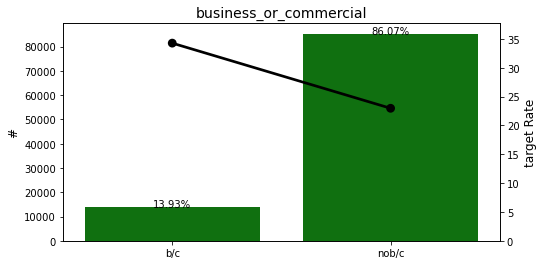

In [37]:
fa.plot_bivar_cat(X_train, y_train, ['business_or_commercial'])

Validemos el modelo para la cartera de sólo Individuos en Prueba.  
Usamos como base de comparación la performance en Entrenamiento.

ALL en Train vs. ALL en Test Individuos Baseline performance report


,cuantil,prob,count,event,non_event,event_rate,odds,per_event,per_non_event,per_event_cmlt,per_non_event_cmlt,lift,KS
0,"(0.0, 0.066]",5.6%,10328,598,9730,5.8%,0.06,2.5%,13.0%,2.5%,13.0%,0.24,10.6%
1,"(0.066, 0.083]",7.5%,9681,653,9028,6.7%,0.07,2.7%,12.1%,5.1%,25.1%,0.27,19.9%
2,"(0.083, 0.102]",9.3%,10109,924,9185,9.1%,0.10,3.8%,12.3%,8.9%,37.4%,0.37,28.4%
3,"(0.102, 0.121]",11.2%,9938,1147,8791,11.5%,0.13,4.7%,11.8%,13.7%,49.1%,0.47,35.5%
4,"(0.121, 0.141]",13.1%,9502,1265,8237,13.3%,0.15,5.2%,11.0%,18.9%,60.1%,0.54,41.3%
5,"(0.141, 0.169]",15.5%,10160,1536,8624,15.1%,0.18,6.3%,11.5%,25.2%,71.7%,0.62,46.5%
6,"(0.169, 0.211]",18.9%,9687,1837,7850,19.0%,0.23,7.6%,10.5%,32.7%,82.2%,0.77,49.4%
7,"(0.211, 0.286]",24.5%,9933,2508,7425,25.2%,0.34,10.3%,9.9%,43.0%,92.1%,1.03,49.1%
8,"(0.286, 1.0]",70.2%,19775,13857,5918,70.1%,2.34,57.0%,7.9%,100.0%,100.0%,2.86,0.0%
9,"(0.0, 1.0]",24.5%,99113,24325,74788,24.5%,0.33,100.0%,100.0%,100.0%,100.0%,1.00,49.4%


ALL en Train vs. ALL en Test Individuos Testing performance report


,cuantil,prob,count,event,non_event,event_rate,odds,per_event,per_non_event,per_event_cmlt,per_non_event_cmlt,lift,KS
0,"(0.0, 0.066]",5.6%,5076,308,4768,6.1%,0.06,3.1%,14.6%,3.1%,14.6%,0.26,11.4%
1,"(0.066, 0.083]",7.5%,4802,333,4469,6.9%,0.07,3.4%,13.7%,6.5%,28.2%,0.30,21.7%
2,"(0.083, 0.102]",9.3%,4824,487,4337,10.1%,0.11,4.9%,13.3%,11.4%,41.5%,0.44,30.0%
3,"(0.102, 0.121]",11.2%,4702,530,4172,11.3%,0.13,5.4%,12.7%,16.8%,54.2%,0.49,37.4%
4,"(0.121, 0.141]",13.1%,4304,576,3728,13.4%,0.15,5.8%,11.4%,22.6%,65.6%,0.58,43.0%
5,"(0.141, 0.169]",15.5%,4408,642,3766,14.6%,0.17,6.5%,11.5%,29.1%,77.1%,0.63,48.0%
6,"(0.169, 0.211]",18.8%,3704,745,2959,20.1%,0.25,7.5%,9.0%,36.7%,86.2%,0.87,49.5%
7,"(0.211, 0.286]",24.5%,3648,894,2754,24.5%,0.32,9.1%,8.4%,45.7%,94.6%,1.06,48.8%
8,"(0.286, 1.0]",75.1%,7132,5357,1775,75.1%,3.02,54.3%,5.4%,100.0%,100.0%,3.24,0.0%
9,"(0.0, 1.0]",23.0%,42600,9872,32728,23.2%,0.30,100.0%,100.0%,100.0%,100.0%,1.00,49.5%


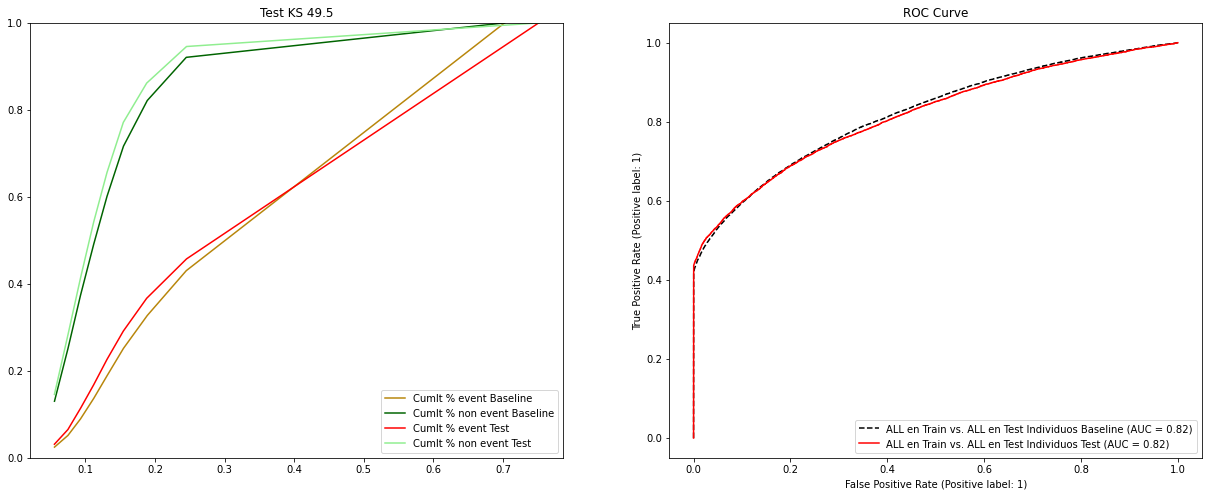

In [38]:
ind_test_msk = (X_test['business_or_commercial'] == 'nob/c')
rep = fa.bsl_vs_test_report(bsl_score = y_train_score, bsl_target = y_train, 
                         test_score = y_test_score[ind_test_msk], test_target = y_test[ind_test_msk], 
                         nbins=10, score_model_name='ALL en Train vs. ALL en Test Individuos')

### en Datos Externos

Para conveniencia mostramos como podemos validar en datos externos.  El único requerimiento para aplicar el Pipeline es que las columnas sean idénticas a las del conjunto de Entrenamiento.

In [39]:
Xy_test_comm = pd.concat([X_test[X_test['business_or_commercial'] == 'b/c'], 
                        y_test[X_test['business_or_commercial'] == 'b/c']], axis = 1)
print(Xy_test_comm.shape)

(6957, 35)


In [40]:
Xy_test_comm.to_csv('Segmento Comercial.csv', index=False)

In [41]:
Ext_data = pd.read_csv('Segmento Comercial.csv')

In [42]:
y_test_comm = Ext_data['Status']
y_test_comm_score = model_pipe.predict_proba(Ext_data.drop('Status', axis=1))[:,1]

ALL en Train vs. ALL en Test Datos Externos (Seg. Comercial) Baseline performance report


,cuantil,prob,count,event,non_event,event_rate,odds,per_event,per_non_event,per_event_cmlt,per_non_event_cmlt,lift,KS
0,"(0.0, 0.066]",5.6%,10328,598,9730,5.8%,0.06,2.5%,13.0%,2.5%,13.0%,0.24,10.6%
1,"(0.066, 0.083]",7.5%,9681,653,9028,6.7%,0.07,2.7%,12.1%,5.1%,25.1%,0.27,19.9%
2,"(0.083, 0.102]",9.3%,10109,924,9185,9.1%,0.10,3.8%,12.3%,8.9%,37.4%,0.37,28.4%
3,"(0.102, 0.121]",11.2%,9938,1147,8791,11.5%,0.13,4.7%,11.8%,13.7%,49.1%,0.47,35.5%
4,"(0.121, 0.141]",13.1%,9502,1265,8237,13.3%,0.15,5.2%,11.0%,18.9%,60.1%,0.54,41.3%
5,"(0.141, 0.169]",15.5%,10160,1536,8624,15.1%,0.18,6.3%,11.5%,25.2%,71.7%,0.62,46.5%
6,"(0.169, 0.211]",18.9%,9687,1837,7850,19.0%,0.23,7.6%,10.5%,32.7%,82.2%,0.77,49.4%
7,"(0.211, 0.286]",24.5%,9933,2508,7425,25.2%,0.34,10.3%,9.9%,43.0%,92.1%,1.03,49.1%
8,"(0.286, 1.0]",70.2%,19775,13857,5918,70.1%,2.34,57.0%,7.9%,100.0%,100.0%,2.86,0.0%
9,"(0.0, 1.0]",24.5%,99113,24325,74788,24.5%,0.33,100.0%,100.0%,100.0%,100.0%,1.00,49.4%


ALL en Train vs. ALL en Test Datos Externos (Seg. Comercial) Testing performance report


,cuantil,prob,count,event,non_event,event_rate,odds,per_event,per_non_event,per_event_cmlt,per_non_event_cmlt,lift,KS
0,"(0.0, 0.066]",6.2%,8,2,6,25.0%,0.33,0.1%,0.1%,0.1%,0.1%,0.71,0.1%
1,"(0.066, 0.083]",7.8%,74,6,68,8.1%,0.09,0.2%,1.5%,0.3%,1.6%,0.23,1.3%
2,"(0.083, 0.102]",9.4%,214,18,196,8.4%,0.09,0.7%,4.3%,1.1%,6.0%,0.24,4.9%
3,"(0.102, 0.121]",11.2%,397,43,354,10.8%,0.12,1.8%,7.8%,2.8%,13.8%,0.31,11.0%
4,"(0.121, 0.141]",13.1%,419,53,366,12.6%,0.14,2.2%,8.1%,5.0%,21.9%,0.36,16.9%
5,"(0.141, 0.169]",15.5%,574,94,480,16.4%,0.20,3.8%,10.6%,8.8%,32.6%,0.47,23.7%
6,"(0.169, 0.211]",19.1%,1061,223,838,21.0%,0.27,9.1%,18.6%,18.0%,51.1%,0.60,33.1%
7,"(0.211, 0.286]",24.4%,1402,364,1038,26.0%,0.35,14.9%,23.0%,32.9%,74.1%,0.74,41.2%
8,"(0.286, 1.0]",59.0%,2808,1639,1169,58.4%,1.40,67.1%,25.9%,100.0%,100.0%,1.66,0.0%
9,"(0.0, 1.0]",34.7%,6957,2442,4515,35.1%,0.54,100.0%,100.0%,100.0%,100.0%,1.00,41.2%


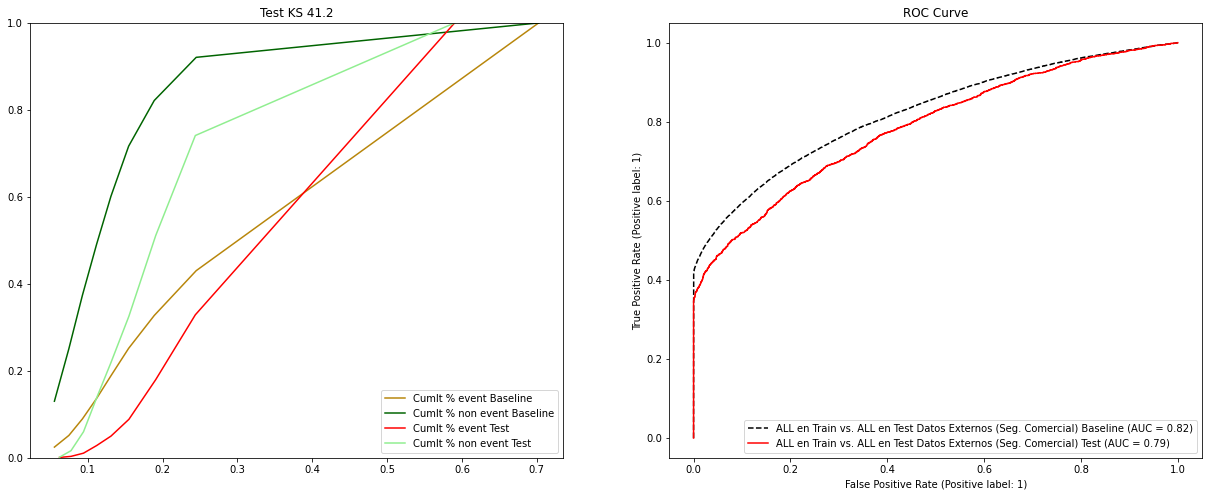

In [43]:
rep = fa.bsl_vs_test_report(bsl_score = y_train_score, bsl_target = y_train, 
                         test_score = y_test_comm_score, test_target = y_test_comm, 
                         nbins=10, score_model_name='ALL en Train vs. ALL en Test Datos Externos (Seg. Comercial)')

## Apéndice

### Referencias librerías de ML

Scikit Learn: https://scikit-learn.org/stable/getting_started.html  
Feature Engine: https://feature-engine.readthedocs.io/en/latest/quickstart/index.html

### Referencia de funciones auxiliares

A continuación mostramos una referencia rápida de las funciones auxiliares de la librería Func_aux_v2.py. 
Notar que podemos consultar la documentación de cada función como cualquier otra función python con help(). 

#### `plot_univar_cat()`

In [44]:
help(fa.plot_univar_cat)

Help on function plot_univar_cat in module fa.Plots:

plot_univar_cat(df, col)
    Grafica en barras los valores de una columna de un DataFrame
    
    Parámetros
    __________
    df : pandas.DataFrame
       tabla que contiene la columna
    col : str
       nombre de la columna 
       
    Retorna
    _______
    None
       Muestra el gráfico
    
    Ejemplo
    _______
    import fa as fa
    fa.plot_univar_cat(df, 'Gender')



#### `plot_bivar_cat()`

In [45]:
help(fa.plot_bivar_cat)

Help on function plot_bivar_cat in module fa.Plots:

plot_bivar_cat(df, target, cols=None, vis_col=2, target_lbl='target', max_n_vals=20, discr_round=3)
    Grafica en barras y lineas lista de columnas de un DataFrame 
    
    Para cada columna de la lista dada se realiza un gráfico de barras y líneas.
    Las barras muestran los números de observaciones mientras que los puntos muestran 
    la proporción de observaciones con target = 1.
    Los gráficos se disponen en un arreglo rectangular con 
    vis_col columnas de visualización.
    
    Parámetros
    __________
    df : pandas.DataFrame
       tabla con la lista de columnas
    cols : list
       lista de nombres de columna
    vis_col : int = 2
       cantidad de columnas de visualización del gráfico múltiple.
    target_lbl : str = 'Status'
       nombre de la columna usada como target.
    max_n_vals : int = 20
       número máximo de categorías distintas para mostrar en un gráfico.
    discr_round : int = 3
       cantidad

#### `plot_bivar_cont()`

In [46]:
help(fa.plot_bivar_cont)

Help on function plot_bivar_cont in module fa.Plots:

plot_bivar_cont(df, target, cols=None, vis_col=2, target_lbl='target', nbins=10, discr_round=3)
    Grafica en barras y lineas lista de columnas de un DataFrame 
    
    Para cada columna de la lista dada se realiza un gráfico de barras y líneas.
    Las barras muestran los números de observaciones mientras que los puntos muestran 
    la proporción de observaciones con target = 1.
    Los gráficos se disponen en un arreglo rectangular con 
    vis_col columnas de visualización.
    
    Parámetros
    __________
    df : pandas.DataFrame
       tabla con la lista de columnas
    cols : list
       lista de nombres de columna
    vis_col : int = 2
       cantidad de columnas de visualización del gráfico múltiple.
    target_lbl : str = 'Status'
       nombre de la columna usada como target.
    nbins : int = 10
       número de cuantiles o bines usados para discretizar cada columna. Por defecto, 
       se parte la columna continua

#### `desc_cols_by_target()`

In [47]:
help(fa.desc_cols_by_target)

Help on function desc_cols_by_target in module fa.Reports:

desc_cols_by_target(df, cols, target, **kwargs)
    Describe columnas por cada nivel de target 
    
    Para cada columna de la lista dada se construye una tabla con estadísticos que resumen la distribución de la columna por cada valor de "target". 
    Para las variables numéricas se muestran la cantidad, media, desvío estándar, mínimo, cuantiles 25%, 50% y 75%, máximo y cantidad y porcentaje de nulos.
    Para las variables categóricas se muestran la cantidad, la cantidad de valores únicos, el valor más frecuente, y la cantidad y porcentaje de nulos.
     
    Parámetros
    __________
    df : pandas.DataFrame
       tabla con la lista de columnas a describir
    cols : list
       lista de nombres de columna
    target : pandas.Series
       vector con los valores de target. No es necesario que pertenezca a df.
    **kwargs: keyword arguments
       lista de argumentos pasadas a la función describe() original. 
       htt

#### `model_coef()`

In [48]:
help(fa.model_coef)

Help on function model_coef in module fa.Plots:

model_coef(model_pipeline, title)
    Grafica los coeficientes de un pipeline con ajuste logístico 
    
    Parámetros
    __________
    model_pipeline : sklearn.pipeline.Pipeline
       Pipeline de scikit-learn.  El último paso debe ser un ajuste lineal o logístico.
    title: str
       Título del gráfico
       
    Retorna
    _______
    None
       Muestra el gráfico
            
    Ejemplo
    _______
    import fa as fa
    fa.model_coef(model_pipe, "Modelo Logístico")



#### `bsl_vs_test_report()`

In [49]:
help(fa.bsl_vs_test_report)

Help on function bsl_vs_test_report in module fa.Reports:

bsl_vs_test_report(bsl_score, bsl_target, test_score, test_target, nbins=10, score_model_name='Modelo v1')
    Reportes comparados de scores de referencia y scores de prueba
    
    Reportan la performance de dos predicciones,  primero "baseline" o de referencia y luego "test" o prueba. 
    Además se muestran los gráficos de KS y ROC de los dos scores o predicciones.     
        
    Parámetros
    __________
    bsl_score : pandas.Series 
       vector con los scores para el reporte de referencia 
    bsl_target : pandas.Series
       vector con los valores de target para el reporte de referencia
    test_score : pandas.Series
       vector con los scores para el reporte de prueba 
    test_target : pandas.Series
       vector con los valores de target para el reporte de prueba
    nbins : int = 10, list[int] ó intervalIndex
       especificación para el binning de los reportes.
    score_model_name : str = 'Modelo v1'
    

#### `model_report()`

In [50]:
help(fa.model_report)

Help on function model_report in module fa.Reports:

model_report(score, target, quantiles, score_model_name)
    Reporte de performance
    
    Se construye una tabla con el reporte de performance. 
    Los scores se dividen según la especificación dada en quantiles. 
    El binning se puede especificar de 3 maneras. 
    Si es un natural b se divide el vector de scores en b intervalos con aproximadamente la misma cantidad de observaciones. 
    Si es una lista[b0, b1, ..., bn] se construyen los intervalos de score (b0, b1], (b1, b2], ..., (b(n-1), bn].
    Si es de clase InvtervalIndex se usa la función pandas.cut directamente.    
    
    Parámetros
    __________
    score : pandas.Series
       vector con los scores para el reporte de performance
    target : pandas.Series
       vector con los valores de target para el reporte de performance
    quantiles : int = 10, list[int] ó intervalIndex
       especificación para el binning de los reportes.
    score_model_name : str = 'M

#### `bins()`

In [51]:
help(fa.bins)

Help on function bins in module fa.Reports:

bins(scores, nbins=10, left_limit=0, right_limit=1)
    Especificación de cortes para "binning"
    
    Los scores se dividen según la especificación dada por el resto de los parámetros.  'nbins' especifica la cantidad de intervalos de aprox. igual frecuencia. 'left_limit' y 'right_limit' especifican los límites absolutos de los cortes.  Notar que por defecto se espera que los scores sean probabilidades estimadas.  Si los scores se situan en el rango 1 a 999, se puede usar left_limit = 0 y right_limit = 999. 
    
    Parámetros
    __________
    score : pandas.Series
       vector con los scores
    nbins : int = 10 
       número para corte en intervalos de aprox. igual frecuencia
    left_limit: int = 0 
       extremo inferior del primer corte 
    right_limit : int = 1 
       extremo superior del último corte 
    
    Retorna
    _______
    pandas.IntervalIndex
       lista de cortes para aplicar en binnings.
            
    Ejemp